<h1> Visualization YOLO efficiency </h1>

Be sure to have run the following commands before running this notebook:

In [ ]:
! python pre_process_lisa.py
# (if that does not work, run this command line inside a terminal)

Also be sure to have the following folder architecture:
- LISA_TS/
    - aiua120214-0/
    - aiua120214-1/
    - ...
    - readme.txt
    - videoSources.txt
    
    
- LISA_TS_extension/
    - 2014-04-24_10-59/
    - 2014-04-24_11-43/
    - ...
    - 2014-07-11_13-47/
    - allTrainingAnnotations.csv
    
    
- weights/
    - trained_weights_final.h5

(To obtain *trained_weights_final.h5* either:
- train the network by running *python train.py* (follow the readme instructions for more information, it needs a GPU and takes ~2 days for 150 epochs)
- or ask Louis for the last trained weights
)

<h2> Loss evolution in training</h2>(On the training dataset and the validation dataset)

abscisse units: epoch
screenshots from tensorflow
(last update 03/06/2019)

<table><tr>
    <td> <img src="screenshots/loss.png" width=500> </td>
    <td> <img src="screenshots/val_loss.png" width=500> </td>
</tr></table>

In [1]:
from tqdm import tqdm_notebook as tqdm
import numpy as np
import matplotlib.pyplot as plt

<h2> Accuracy computing </h2>

Load the yolo model

In [3]:
from eval_utils import YOLOPlus

model_path = "logs/003/trained_weights_final.h5"
classes_path = "model_data/lisa_classes.txt"

yolo = YOLOPlus(model_path=model_path, classes_path=classes_path)

logs/003/trained_weights_final.h5 model, anchors, and classes loaded.


<h3> Accuracy on train + validation dataset </h3>

In [5]:
from eval_utils import load_data, load_classes

train_dict, train_imgs = load_data("train_lisa_20_12.txt")
classes = load_classes("model_data/lisa_classes.txt")

In [4]:
from eval_utils import detect_img, prediction_not_ok

n_examples = 10 #len(train_imgs)
indices = np.random.choice(len(train_imgs), n_examples, replace=False)

n_good_predictions = 0
wrong_images_paths = []
mistakes_type = []
for input_path in tqdm(np.array(train_imgs)[indices]):
    r_image, labels, scores, boxes = detect_img(input_path, yolo, score_threshold=0.4)
    
    true_infos = train_dict[input_path]
    true_boxes = [info[0:4] for info in true_infos]
    true_labels = [info[4] for info in true_infos]
    
    whole_pred_ok = True
    for label, score, box in zip(labels, scores, boxes):
        local_pred_ok = False
        for true_box, true_label in zip(true_boxes, true_labels):
            local_pred_ok = local_pred_ok or\
                    not prediction_not_ok(score, true_label, true_box, label, box)
        whole_pred_ok = whole_pred_ok and local_pred_ok
    n_good_predictions += whole_pred_ok
    
    
    if not whole_pred_ok or True:  # FixMe: remove the or True
        # *** Uncomment this line to display the wrong predictions ***
        r_image.show()
        wrong_images_paths.append(input_path)
        

print("average accuracy (train): ", round((n_good_predictions * 100)/n_examples, 2), "%")


average accuracy (train):  90.0 %


avg accuracy: 96.17%

In [ ]:
# Little exploration of the mistakes
import time

for image_path in wrong_images_paths:
    r_image, labels, scores, boxes = detect_img(image_path, yolo, 0.4)
    true_infos = train_dict[image_path]
    true_boxes = [info[0:4] for info in true_infos]
    true_labels = [info[4] for info in true_infos]
    print("True boxes: ", true_boxes)
    print("True labels: ", [classes[label] for label in true_labels])
    print("boxes: ", boxes)
    print("labels: ", [classes[label] for label in labels])
    print("scores: ", scores)
    print()
    
    time.sleep(3)
    r_image.show()
    #time.sleep(3)

In [7]:
print("average accuracy (train): ", round((n_good_predictions * 100)/n_examples, 2), "%")

average accuracy (train):  92.0 %


<h3> Accuracy on extension dataset </h3>

In [6]:
test_dict, test_imgs = load_data("test_lisa_20_12.txt")

In [9]:
from eval_utils import detect_img, prediction_not_ok

n_examples = len(test_imgs)
indices = np.random.choice(len(test_imgs), n_examples, replace=False)

n_good_predictions = 0
wrong_images_paths_test = []
mistakes_type = []
for input_path in tqdm(np.array(test_imgs)[indices]):
    r_image, labels, scores, boxes = detect_img(input_path, yolo, score_threshold=0.4)
    
    true_infos = test_dict[input_path]
    true_boxes = [info[0:4] for info in true_infos]
    true_labels = [info[4] for info in true_infos]
    
    whole_pred_ok = True
    for label, score, box in zip(labels, scores, boxes):
        local_pred_ok = False
        for true_box, true_label in zip(true_boxes, true_labels):
            local_pred_ok = local_pred_ok or\
                    not prediction_not_ok(score, true_label, true_box, label, box)
        whole_pred_ok = whole_pred_ok and local_pred_ok
    n_good_predictions += whole_pred_ok
    
    # *** Uncomment these 2 lines to display the wrong predictions ***
    if not whole_pred_ok:
        # r_image.show()
        wrong_images_paths_test.append(input_path)
        

print("average accuracy (test): ", round((n_good_predictions * 100)/n_examples, 2), "%")

average accuracy (test):  82.04 %


avg accuracy(test): 96.22%

In [ ]:
with open("wrong_images_paths.txt", "w") as file:
    for path in wrong_images_paths:
        file.write(path + '\n')
    for path in wrong_images_paths_test[:-1]:
        file.write(path + '\n')
    file.write(wrong_images_paths_test[-1])

Store images in a 'mistakes' folder

In [10]:
# To save the mistakes into their corresponding folders
from eval_utils import IoU

def save_img_if_mistake(img_path, r_image, labels, boxes, true_labels, true_boxes):
    """
    If YOLO made a mistake on this image,
    it saves the image r_image, giving it the
    same name as the the name of the original image
    """
    more_or_less_preds_error = len(labels) != len(true_labels)
    
    iou_error = False
    label_error = False
    min_iou_flag = False
    for label, box in zip(labels, boxes):
        for true_label, true_box in zip(true_labels, true_boxes):
            if IoU(box, true_box) >= 0.1:
                min_iou_flag = True
                if label != true_label:
                    label_error = True
                if IoU(box, true_box) < 0.5:
                    iou_error = True
    
    if label_error:
        r_image.save("mistakes/label/" + path.split("/")[-1])
    if iou_error:
        r_image.save("mistakes/iou/" + path.split("/")[-1])
    if more_or_less_preds_error:
        r_image.save("mistakes/more_or_less_preds/" + path.split("/")[-1])
        

# for path in tqdm(wrong_images_paths):
#     r_image, labels, scores, boxes = detect_img(path, yolo, 0.4)
#     true_infos = train_dict[path]
#     true_boxes = [info[0:4] for info in true_infos]
#     true_labels = [info[4] for info in true_infos]
#     
#     save_img_if_mistake(path, r_image, labels, boxes, true_labels, true_boxes)
        
        
for path in tqdm(wrong_images_paths_test):
    r_image, labels, scores, boxes = detect_img(path, yolo, 0.4)
    true_infos = test_dict[path]
    true_boxes = [info[0:4] for info in true_infos]
    true_labels = [info[4] for info in true_infos]
    
    save_img_if_mistake(path, r_image, labels, boxes, true_labels, true_boxes)

In [ ]:
print("average accuracy (test): ", round((n_good_predictions * 100)/n_examples, 2), "%")

In [ ]:
# to save the mistakes info into a dictionnary
mistakes_info_dict = {}
for path in tqdm(wrong_images_paths):
    r_image, labels, scores, boxes = detect_img(path, yolo, 0.4)
    true_infos = train_dict[path]
    true_boxes = [info[0:4] for info in true_infos]
    true_labels = [info[4] for info in true_infos]
    
    mistakes_info_dict[path]= {
        "true_boxes": true_boxes,
        "true_labels": true_labels,
        "boxes": boxes,
        "labels": labels,
        "scores": score)
    }

for path in tqdm(wrong_images_paths_test):
    r_image, labels, scores, boxes = detect_img(path, yolo, 0.4)
    true_infos = test_dict[path]
    true_boxes = [info[0:4] for info in true_infos]
    true_labels = [info[4] for info in true_infos]
    
    mistakes_info_dict[path]= {
        "true_boxes": true_boxes,
        "true_labels": true_labels,
        "boxes": boxes,
        "labels": labels,
        "scores": score)
    }

In [ ]:
# to save the dictionnary inside a json
import json

def dump_mistakes(file_name)
    with open(file_name, 'w') as json_file:
        json.dump(mistakes_info_dict, json_file)
        
dump_mistakes('mistakes.json')

<h2> Results summary </h2>

<h4> With test data set = extension data set</h4>
<h4><font color="red">/!\/!\/!\ WITH 1 LABEL BUG /!\/!\/!\</font></h4>

| Metric | train + validation | test        |
|--------|--------------------|-------------|
|Accuracy| **74.0%**          | **48.56%**   |

- Accuracy on the train+validation dataset overall (the original LISA dataset): 74.0%
- Accuracy on the test dataset (the extension LISA dataset): 48.56%

<h4> With test data set = 20% of (original dataset + extension dataset)</h4>
<h4><font color="red">/!\/!\/!\ WITH 1 LABEL BUG /!\/!\/!\</font></h4>

| Metric | RUN n°| train + validation | test        |
|--------|-------|--------------------|-------------|
|Accuracy|   1   | **88.44**          | **84.77**   |

<h4> With test data set = 20% of (original dataset + extension dataset), <u> with scenes separated + flip augmentation </u> <h4>

| Metric | RUN n°| train + validation | test        |
|--------|-------|--------------------|-------------|
|Accuracy|   1   | **96.12**          | **82.04**   |

<h4> With test data set = 20% of (original dataset + extension dataset), <u> with scenes separated + gray scale + flip augmentation </u> </h4>

| Metric | RUN n°| train + validation | test        |
|--------|-------|--------------------|-------------|
|Accuracy|   1   | **93.23**          | **82.52**   |

<h4> With test data set = 20% of (original dataset + extension dataset), with scenes separated </h4>

| Metric | RUN n°| train + validation | test        |
|--------|-------|--------------------|-------------|
|Accuracy|   1   | **96.96**          | **84.94**   |

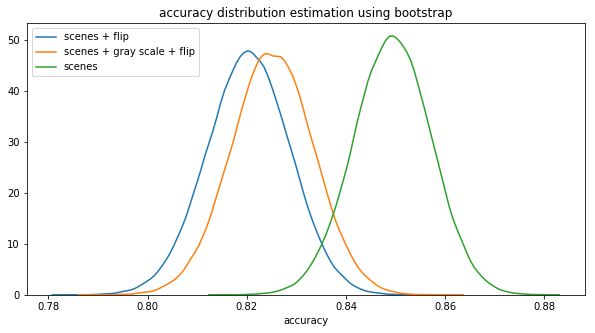

In [6]:
import matplotlib.pyplot as plt
from eval_utils import plot_bootstrap_curve

plt.figure(figsize=(10, 5))

plot_bootstrap_curve(0.8204, 2104, "scenes + flip")
plot_bootstrap_curve(0.8252, 2104, "scenes + gray scale + flip")
plot_bootstrap_curve(0.8494, 2104, "scenes")

plt.title("accuracy distribution estimation using bootstrap")
plt.xlabel("accuracy")
plt.savefig("acc_bootstrap.png")

<h2> Analysis & comments </h2>

<i> OBSOLETE (november 2018) </i>

The model is clearly overfitting the original dataset, interestingly it is overfitting the train and the validation dataset, meaning that the dataset is not diversified enough -> the data augmentation will help a lot, the extension dataset was not used for training so we can try training it on it as well and see the improvement of the accuracy (on the LISA dataset as well as on real world pictures).

The main reasons that lower the accuracy are the following:
- There are quite some pictures where there are two signs or more (but still only 1 is labelled), YOLO will detect all signs or only some of them, and in the accuracy computation, only the first detected sign is considered
- YOLO will sometimes say there is no sign on a picture that contains signs
- YOLO will sometimes identify the sign and its position right but predict a wrong close class (like speed limit 35 instead of speed limit 25)

Since there is no obvious way to compute the accuracy for a detection task, a custom function was used to say whether or not a prediction is considered good, it might need to be changed. (An improvement would be to use the mAP metric: https://medium.com/@jonathan_hui/map-mean-average-precision-for-object-detection-45c121a31173)

These are the criterions to consider a prediction good (Only the first prediction is considered, all others are ignored (there must a smarter way indeed...)):
- There must be at least 1 prediction
- The predicted label must be the same as the true label
- The confidence score must be greater than 0.3
- The Intersection over Union of the predicted and ground truth bounding boxes must be greater than 0.5

/!\ The accuracy was only computed for images that actually contain signs